In [1]:
# -*- coding: utf-8 -*-
"""
@author: Etienne Kras, open in bathymetry_env
"""

# imports 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import geopandas as gpd
import osr
import gdal
import os
import leafmap
import math
import geojson
import datetime
import time
import rasterio
import pandas as pd

from tqdm.notebook import tqdm_notebook
from dateutil.relativedelta import relativedelta
from geojson import Feature, FeatureCollection, dump
from shapely.geometry import Polygon, LineString, MultiLineString, Point
from scipy import stats, interpolate
from google.cloud import storage

# coordinate conversions
SR4326 = osr.SpatialReference()
SR4326.ImportFromEPSG(4326)     # WGS84 / Geographic
SR3857 = osr.SpatialReference()
SR3857.ImportFromEPSG(3857)     # WGS84 / Pseudo-Mercator
ct_4326_to_3857 = osr.CoordinateTransformation(SR4326, SR3857)
ct_3857_to_4326 = osr.CoordinateTransformation(SR3857, SR4326)

# Project specific toggles

In [2]:
# see scheme at acces_api.pdf for a workflow visualization

# project toggles
file_fol = r'p:\11204209-jip-calm\WT4.1_SDB' # name of the local folder for the input data
bucket = 'jip_calm_sdb' # name of the Google Cloud Storage bucket to store files in the cloud
credential_file = r'p:\11204209-jip-calm\WT4.1_SDB\GEE_images\jip-calm-c1886b3313b9.json' # Cloud Storage credential key
overall_project = 'WaddenSea' # name of the overall project
project_name = 'Friese_Zeegat' # name of the project AoI
assessment = 'Subtidal' # either subtidal or intertidal 
draw_tr = 0 # toggle 1 to draw transect(s), 0 to load

# composite image toggles 
compo_int = 3 # composite interval [months]
compo_len = 12 # composite length [months]
scale = 19.109  # output resolution of the image [m]

# validation data
# Note, validation data is not used quantitatively but rather qualitatively to assess the correctness visually
validation = 0 # toggle 1 if validation data is present
val_fol = '' # specify client data folder

# Loading pre-processed files (API)

In [3]:
# authentication
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = credential_file

# get file names
client = storage.Client()
ls = [blob for blob in client.list_blobs(bucket)] 
ProcessedList = [str(blob).split(',')[1][1:] for blob in ls if (project_name in str(blob).split(',')[1][1:] and 
                                                                str(compo_len) in str(blob).split('/')[-1].split('_')[-3] and
                                                                str(compo_int) in str(blob).split('/')[-1].split('_')[-2])]
            
# get data from Google Cloud Storage
tiles = []
tile_paths = []
tile_names = []
tile_times = []
for file in tqdm_notebook(ProcessedList):
    with rasterio.Env(GS_ACCESS_KEY_ID=credential_file):
        tiles.append(gdal.Open(r"https://storage.googleapis.com/{}/{}".format(bucket, file)))
        tile_paths.append(r"https://storage.googleapis.com/{}/{}".format(bucket, file))
        tile_names.append(file.split('/')[-1])
        tile_times.append(file.split('.')[0].split('_')[-6] + ' - ' + file.split('.')[0].split('_')[-5])
        time.sleep(0.01)

  0%|          | 0/25 [00:00<?, ?it/s]

In [87]:
# get data from local drive
tiles = []
tile_paths = []
tile_names = []
tile_times = []
for root, dirs, files in os.walk(os.path.join(file_fol, 'output', assessment, overall_project, project_name)):
    if root == os.path.join(file_fol, 'output', assessment, overall_project, project_name) and len(files) > 0: # access main folder files only
        for file in tqdm_notebook(files):
            if 'xml' not in file and file.split('_')[-3] == str(compo_len) and file.split('_')[-2] == str(compo_int):   
                tiles.append(gdal.Open(os.path.join(file_fol, 'output', assessment, overall_project, project_name, file)))
                tile_paths.append(os.path.join(file_fol, 'output', assessment, overall_project, project_name, file))
                tile_names.append(file)
                tile_times.append(file.split('.')[0].split('_')[-6] + ' - ' + file.split('.')[0].split('_')[-5])
                time.sleep(0.01)

  0%|          | 0/75 [00:00<?, ?it/s]

In [88]:
# get validation data
if validation == 1:
    
    # project to correct coordinate reference system
    for root, dirs, files in os.walk(os.path.join(file_fol, val_fol)):
        if any('_projected' in string for string in files): # check if projection is done before
            continue
        else: # if not, reproject if necessary
            for file in files:
                if '.tif' in file and '.xml' not in file:
                    img = gdal.Open(os.path.join(file_fol, val_fol, file))
                    #srs=osr.SpatialReference(wkt=img.GetProjection())
                    #if srs.GetAttrValue('projcs') != 'WGS 84 / Pseudo-Mercator': # convert coordinates
                    warp = gdal.Warp(os.path.join(file_fol, val_fol, file.split('.')[0] + '_projected.tif'), img, 
                                         dstSRS='EPSG:3857') # warping to correct epsg
                    warp = None # Closes the files    
    
    # get data from local drive
    val_data = []
    val_paths = []
    val_names = []
    val_times = []
    for root, dirs, files in os.walk(os.path.join(file_fol, val_fol)):
        for file in files:
            if '.tif' in file and '.xml' not in file and 'projected' in file:
                val_data.append(gdal.Open(os.path.join(file_fol, val_fol, file)))
                val_paths.append(os.path.join(file_fol, val_fol, file))
                val_names.append(file)
                if 'Q' in file.split('_')[1]:
                    val_times.append(str(file.split('_')[0] + '-' + file.split('_')[1]))
                else:
                    val_times.append(str(file.split('_')[0]))

# Visualization / Use-case (interactive)

In [4]:
# open AoI
with open(os.path.join(file_fol,'AOI\local',project_name+'.geojson')) as f:
    AoIjson = geojson.load(f)

if AoIjson['features'][0]['geometry']['type'] == 'MultiPolygon':
    AoI = Polygon(AoIjson['features'][0]['geometry']['coordinates'][0][0]) 
elif AoIjson['features'][0]['geometry']['type'] == 'Polygon':
    AoI = Polygon(AoIjson['features'][0]['geometry']['coordinates'][0]) 

# initialize map
Map = leafmap.Map(center=[AoI.centroid.xy[1][0], AoI.centroid.xy[0][0]], zoom=11) 
Map.add_basemap(basemap='ROADMAP')

# add first composite to show as base layer
Map.add_local_tile(tile_paths[-1], palette='colorbrewer.sequential.Blues_8_r', layer_name='Composite %s'%tile_times[-1])
#Map.add_raster(tile_paths[0], colormap='Blues_r', layer_name='Composite %s'%tile_times[0])

# add AoI
style = {'fillOpacity':0.01}
hover_style = {'fillOpacity':0.05}
Map.add_geojson(AoIjson, layer_name='AoI', style=style, hover_style=hover_style)

if draw_tr == 1:
    print('Please draw transect(s) at interesting feature(s) of at most 2 points') # identifier
if draw_tr == 0:
    # open transects
    print('Loading and visualizing transect(s) of at most 2 points') #identifier
    for root, dirs, files in os.walk(os.path.join(file_fol,'AOI\local', project_name+'_transects')):
        for file in files:
            if '.geojson' in file:
                Map.add_geojson(os.path.join(file_fol,'AOI\local', project_name+'_transects',file), layer_name='transect %s'%file.split('.')[0].split('_')[1])

# show map
Map

Created LRU Cache for 'tilesource' with 10 maximum size


Loading and visualizing transect(s) of at most 2 points


Map(center=[53.466505999999995, 6.041828], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in…

In [5]:
# construct the AoI if polygon is drawn in cell above

if draw_tr == 1:
    
    print('Constructing transect(s) from drawn line(s)') # identifier
    
    # get transects
    trs = [] # create transect shapefile(s)
    for i in Map.draw_features:
        conv_coords = []
        for coords in i['geometry']['coordinates']:
            mapxg, mapyg, _ = ct_4326_to_3857.TransformPoint(coords[1], coords[0])
            conv_coords.append([mapxg, mapyg])
        trs.append(LineString(conv_coords))
        
    # make folder if output directory does not exist
    if os.path.exists(os.path.join(file_fol,'AOI\local', project_name+'_transects')) == False:
        os.mkdir(os.path.join(file_fol,'AOI\local', project_name+'_transects'))
        
    # export transects
    for idx, (i, j) in enumerate(zip(trs, Map.draw_features)):
        
        # use EPSG4326 for the geojson (to show on the map)
        features = []
        features.append(Feature(geometry=LineString(j['geometry']['coordinates']), properties={"transect": idx+1}))
        crs = {"type": "name","properties": {"name": "EPSG:4326"}}
        feature_collection = FeatureCollection(features, crs=crs)
        with open(os.path.join(file_fol,'AOI\local', project_name+'_transects','transect_%s_4326'%(idx+1)+'.geojson'), 'w') as f: # geojson
            dump(feature_collection, f)
            
        # use EPSG3857 for the shapefile
        gdr = gpd.GeoDataFrame({'properties':['transect %s'%(idx+1)], 'geometry': [i]}, crs='EPSG:3857') #shp
        gdr.to_file(os.path.join(file_fol,'AOI\local', project_name+'_transects','transect_%s_3857'%(idx+1)+'.shp'))
    
if draw_tr == 0:
    print('Reconstructing transect(s) from loaded file(s)')
    # get transects
    trs = []
    for root, dirs, files in os.walk(os.path.join(file_fol,'AOI\local', project_name+'_transects')):
        for file in files:
            if '.geojson' in file:
                with open(os.path.join(file_fol,'AOI\local', project_name+'_transects',file)) as f:
                    trs_file = geojson.load(f)
                    try: # drawn polygon in this script
                        conv_coords = []
                        for coords in trs_file['features'][0]['geometry']['coordinates']:
                            mapxg, mapyg, _ = ct_4326_to_3857.TransformPoint(coords[1], coords[0])
                            conv_coords.append([mapxg, mapyg])
                        trs.append(LineString(conv_coords))
                    except: # drawn in QGIS / ArcGIS and written to geojson there (client file) (Note, has to be EPSG4326)
                        conv_coords = []
                        for coords in trs_file['features'][0]['geometry']['coordinates'][0]:
                            mapxg, mapyg, _ = ct_4326_to_3857.TransformPoint(coords[1], coords[0])
                            conv_coords.append([mapxg, mapyg])
                        trs.append(LineString(conv_coords))

Reconstructing transect(s) from loaded file(s)


In [6]:
# get raster values for multiple bands
def raster_values(x,y,layer,bands,gt):
    col=[]
    px = int((x - gt[0]) / gt[1])
    py =int((y - gt[3]) / gt[5])
    for j in range(bands):
        band = layer.GetRasterBand(j+1)
        ndv = band.GetNoDataValue()
        data = band.ReadAsArray(px,py, 1, 1)
        if data == None: # no values found
            col.append(np.nan)
        else: # found values, start appending
            value = data[0][0]
            if value != ndv and round(value,1)!=-float('inf'):
                col.append(data[0][0])
            elif value == ndv or round(value,1)==-float('inf'):
                col.append(np.nan) # no data value
    return col

In [7]:
# calculate elevation along drawn / loaded transect(s)

# get values along a transect
tx = []
ty = []
tzg = []
tmask = []
td = []
td_corr = []
for tr in trs:
    x = []
    y = []
    zg = []
    mask = []
    d = []
    d_corr = []
    for composite in tiles:
        # composite characteristics
        gt = composite.GetGeoTransform()
        bands = composite.RasterCount
        
        # filtering values
        length=tr.length # in m 
        
        # correct transect length and scale (EPSG:3857 is distorted away from the equator, i.e. at higher latitudes)
        start_coord = ct_3857_to_4326.TransformPoint(tr.coords.xy[0][0], tr.coords.xy[1][0]) # start latitude
        end_coord = ct_3857_to_4326.TransformPoint(tr.coords.xy[0][1], tr.coords.xy[1][1]) # end latitude
        length_corr = length*np.cos(np.radians(np.mean([start_coord[0], end_coord[0]]))) # easy correction(short distances)
        scale_corr = scale*np.cos(np.radians(np.mean([start_coord[0], end_coord[0]]))) # easy correction (short distances)
    
        xs = []
        ys = []
        zgs = []
        masks = []
        ds = []
        ds_corr = []
        for currentdistance, corrdistance in zip(np.arange(0,length,scale), np.arange(0,length_corr,scale_corr)):
            point = tr.interpolate(currentdistance) 
            xp,yp=point.x, point.y
            xs.append(xp), ys.append(yp) # appending
            # append the elevations
            zgs.append(raster_values(xp,yp,composite,bands,gt)[0]) # single value, either red = 0, green = 1, blue = 2
            #zgs.append(np.mean(raster_values(xp,yp,composite,bands,gt)[0:3])) # multiple mean, red = 0, green = 1, blue = 2
            masks.append(raster_values(xp,yp,composite,bands,gt)[3]<=0) # watermask, smaller than zero --> land
            ds.append(currentdistance)
            ds_corr.append(corrdistance) # only used here, not for finding values as .tif is not corrected
        zgcorr = np.array(zgs)
        zgcorr[np.array(masks)] = np.nan # mask uit trues (land)
        
        # appending
        x.append(np.array(xs))
        y.append(np.array(ys))
        zg.append(zgcorr)
        mask.append(np.array(masks))
        d.append(np.array(ds))
        d_corr.append(np.array(ds_corr))
        
    # appending
    tx.append(x)
    ty.append(y)
    tzg.append(zg)
    tmask.append(mask)
    td.append(d)   
    td_corr.append(d_corr)

In [8]:
# get validation data on transects
if validation == 1:
    tzg_val = []
    for tr in trs:
        zg_val = []
        for val in val_data:
            # composite characteristics
            gt = val.GetGeoTransform() # top left x, w-e pixel res, skewness x, top left y, skewness y, n-s pixel res
            bands = val.RasterCount
    
            # filtering values
            length=tr.length # in m 
            
            # correct transect length and scale (EPSG:3857 is distorted away from the equator, i.e. at higher latitudes)
            start_coord = ct_3857_to_4326.TransformPoint(tr.coords.xy[0][0], tr.coords.xy[1][0]) # start latitude
            end_coord = ct_3857_to_4326.TransformPoint(tr.coords.xy[0][1], tr.coords.xy[1][1]) # end latitude
            length_corr = length*np.cos(np.radians(np.mean([start_coord[0], end_coord[0]]))) # easy correction (short distances)
            scale_corr = scale*np.cos(np.radians(np.mean([start_coord[0], end_coord[0]]))) # easy correction (short distances)
            
            zgs = []
            for currentdistance, corrdistance in zip(np.arange(0,length,scale), np.arange(0,length_corr,scale_corr)):
                point = tr.interpolate(currentdistance) 
                xp,yp=point.x, point.y
                # append the validation elevations
                zgs.append(raster_values(xp,yp,val,bands,gt)[0]) 
            
            # appending
            zg_val.append(np.array(zgs))
            
        # appending
        tzg_val.append(zg_val)

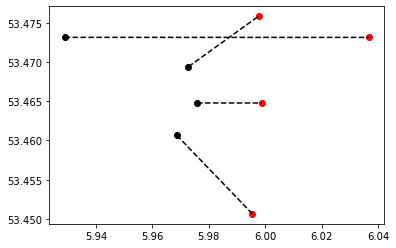

In [10]:
# small indicative plot to get the direction of the transects
# note, this is also derived from the directions..
for root, dirs, files in os.walk(os.path.join(file_fol,'AOI\local', project_name+'_transects')):
        for file in files:
            if '.geojson' in file:
                with open(os.path.join(file_fol,'AOI\local', project_name+'_transects',file)) as f:
                    gj = geojson.load(f)
                    if gj['features'][0]['geometry']['type'] == 'LineString': cds = gj['features'][0]['geometry']['coordinates']
                    if gj['features'][0]['geometry']['type'] == 'MultiLineString': cds = gj['features'][0]['geometry']['coordinates'][0]
                    plt.plot(*zip(cds[0]), 'ko') # starts
                    plt.plot(*zip(cds[1]), 'ro') # ends
                    plt.plot(LineString(cds).coords.xy[0],
                             LineString(cds).coords.xy[1], 'k--')

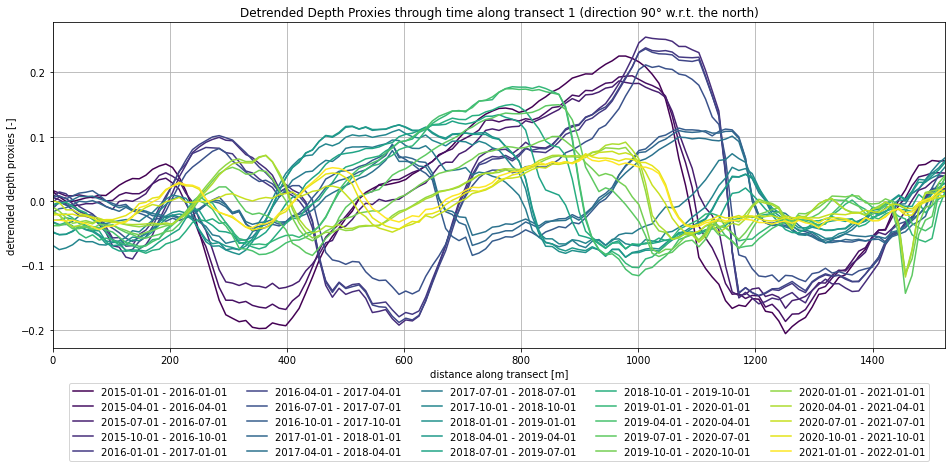

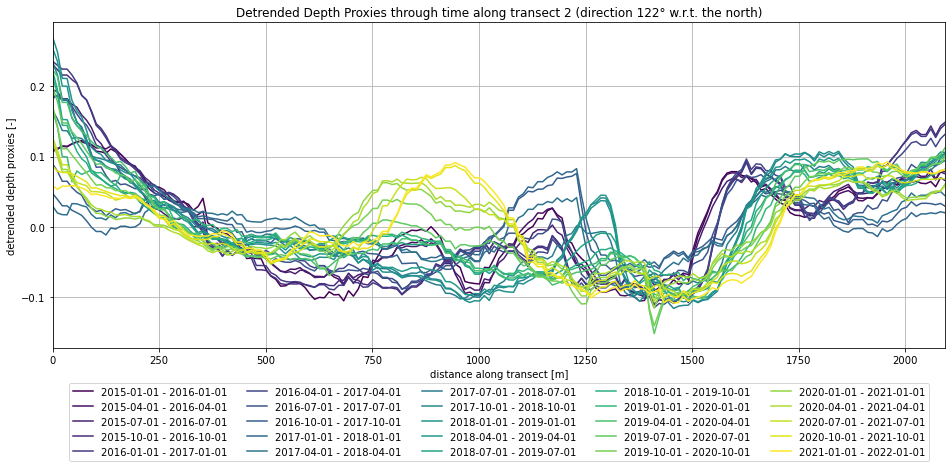

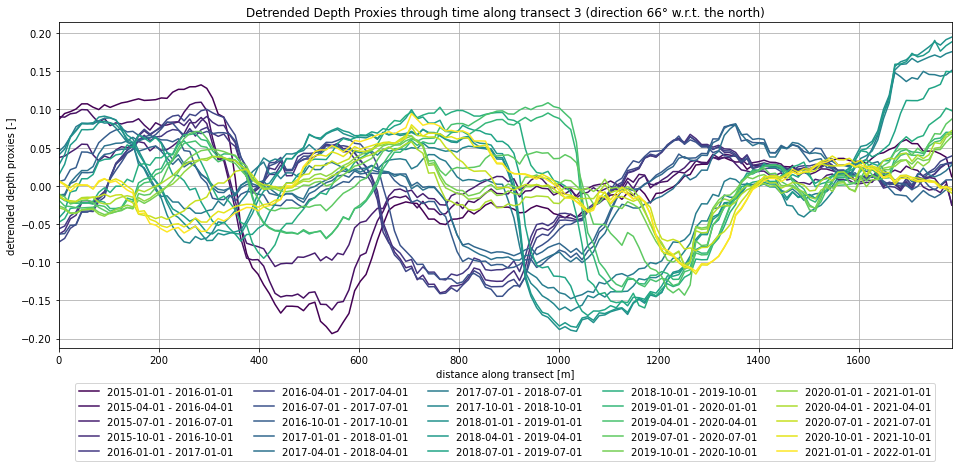

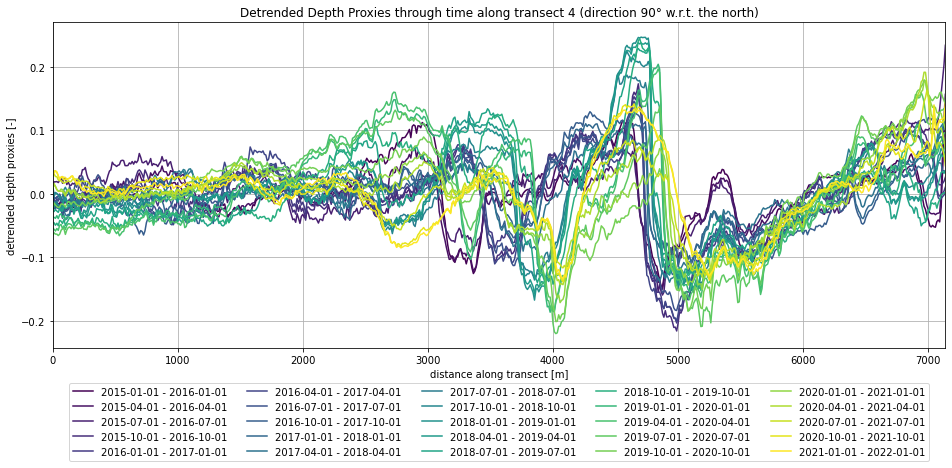

In [12]:
# plot elevations along drawn / loaded transect(s)
filter_val_yr = 0 # toggle 1 if only to show composites closest to survey (validation) data

detr_zs = []
val_detr_zs = []
val_detr_ts = []
for idv, (xtr, ytr, dtr, dtrc, zgtr, masktr, tr) in enumerate(zip(tx, ty, td, td_corr, tzg, tmask, trs)):
    angle=math.degrees(math.atan2(tr.coords.xy[0][1] - tr.coords.xy[0][0], 
                                  tr.coords.xy[1][1] - tr.coords.xy[1][0])) % 360 # modulo, w.r.t degrees north
    
    fig, ax = plt.subplots(figsize=(16,6))
    plt.title('Detrended Depth Proxies through time along transect %s (direction %s\xb0 w.r.t. the north)'%(idv+1, 
                                                                                                            int(angle)))
    
    # validation data
    if validation == 1:
        val_times_pl = [] # keep times of plotted validation data
        ax2=ax.twinx()
        colors = cm.copper(np.linspace(0, 1, len(tzg_val[idv])))
        for vd, tm, col in zip(tzg_val[idv], val_times, colors):
            if np.isnan(vd).all() == False: # check if not all nans to plot
                ax2.plot(dtrc[idv], vd, color=col, linewidth=5, linestyle='--', label = '%s'%tm)
                val_times_pl.append(tm)
           
        # plot characteristics
        ax2.set_ylabel('validation data [m]',color='brown')
        ax2.legend(loc='upper center', bbox_to_anchor=(1.1, 0.65), ncol=1)
    
    colors = cm.viridis(np.linspace(0, 1, len(zgtr)))
    det_z = []
    val_det_z = []
    val_det_t = []
    plotted = []
    for idx, (xs, ys, ds, dsc, zgs, masks, name, col) in enumerate(zip(xtr, ytr, dtr, dtrc, zgtr, masktr, 
                                                                       tile_names, colors)):
        
        # detrending and plotting
        masked = ~np.isnan(ds) & ~np.isnan(zgs)
        result = stats.linregress(ds[masked], zgs[masked])
        trend = result.intercept + result.slope*ds
        detrended = [zgs[j]-trend[j] for j in range(0, len(ds))]
        det_z.append(detrended)
        #RMSE = np.sqrt(np.nanmean(result.rvalue**2)) # root of the mean squared residual of the detrended fit
        #Rsq = result.rvalue**2 # R-squared residual of the detrended fit
        
        # plot by taking out the trend (bias, linear regression)
        name_start = name.split('.')[0].split('_')[-6]
        name_end = name.split('.')[0].split('_')[-5]
        
        if filter_val_yr == 1:
            center_time = pd.Timestamp(name_start)+(pd.Timestamp(name_end) - pd.Timestamp(name_start))/2
            survey_time = pd.PeriodIndex(val_times_pl, freq='Q').to_timestamp()
            for i in survey_time:
                if abs((i-center_time).days) < 5: # check in the range of 10 days around center of composite
                    if i not in plotted:
                        ax.plot(dsc, detrended, color=col, label='%s - %s'%(name_start, name_end))
                        val_det_z.append(detrended)
                        val_det_t.append(name_start + ' - ' + name_end)
                    plotted.append(i) # do not show duplicates
        if filter_val_yr == 0:
            ax.plot(dsc, detrended, color=col, label='%s - %s'%(name_start, name_end))
    
    # show what is land
    for idx, i in enumerate(dtrc[0][np.all(masktr, axis=0)]): # lengths where there is always land throughout the composites
        if idx == 0: plt.axvline(i, color='goldenrod', alpha=0.3, label='always land (verticals)')
        else: plt.axvline(i, color='goldenrod', alpha=0.3)
    
    # plot characteristics
    ax.set_xlim(dtrc[0][0], dtrc[0][-1]);
    ax.set_xlabel('distance along transect [m]')
    ax.set_ylabel('detrended depth proxies [-]')
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.09), ncol=5)
    ax.grid()
            
    # make folder if output directory does not exist
    if os.path.exists(os.path.join(file_fol,'AOI\local', project_name+r'_transects\figs')) == False:
        os.mkdir(os.path.join(file_fol,'AOI\local', project_name+r'_transects\figs'))
        
    # save figure
    #if filter_val_yr == 0:
    #    plt.savefig(os.path.join(file_fol,'AOI\local', project_name+r'_transects\figs\transect_%s_compo_%s.png'%(idv+1, compo_len)), 
    #                bbox_inches='tight', facecolor='white')
    #if filter_val_yr == 1:
    #    plt.savefig(os.path.join(file_fol,'AOI\local', project_name+r'_transects\figs\transect_%s_compo_%s_validation_data.png'%(idv+1, compo_len)), 
    #                bbox_inches='tight', facecolor='white')
    
    # appending detrended values
    detr_zs.append(det_z)
    val_detr_zs.append(val_det_z)
    val_detr_ts.append(val_det_t)

In [13]:
# required functions to calculate cross-correlation in next cell

# function to find nearest index
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

# function to get 1D cross correlation (returning max corr and the lag (in x-direction))
def cross_corr(y1, y2):
    """Calculates the cross correlation and lags without normalization.

    The definition of the discrete cross-correlation is in:
    https://www.mathworks.com/help/matlab/ref/xcorr.html

    Returns:
      max_corr: Maximum correlation without normalization.
      lag: The lag in terms of the index.
    """
    if len(y1) != len(y2):
        raise ValueError('The lengths of the inputs should be the same.')

    y1_auto_corr = np.dot(y1, y1) / len(y1)
    y2_auto_corr = np.dot(y2, y2) / len(y1)
    corr = np.correlate(y1, y2, mode='same')
    # The unbiased sample size is N - lag.
    unbiased_sample_size = np.correlate(
        np.ones(len(y1)), np.ones(len(y1)), mode='same')
    corr = corr / unbiased_sample_size / np.sqrt(y1_auto_corr * y2_auto_corr)
    shift = len(y1) // 2

    max_corr = np.max(corr)
    argmax_corr = np.argmax(corr)
    lag = argmax_corr - shift # index
    return max_corr, lag

Composite to composite summed total migration and rate (direction 90° w.r.t. the north): 310 m and 51.666666666666664 m/yr
Overall total migration (direction 90° w.r.t. the north): 274 m and 45.7 m/yr


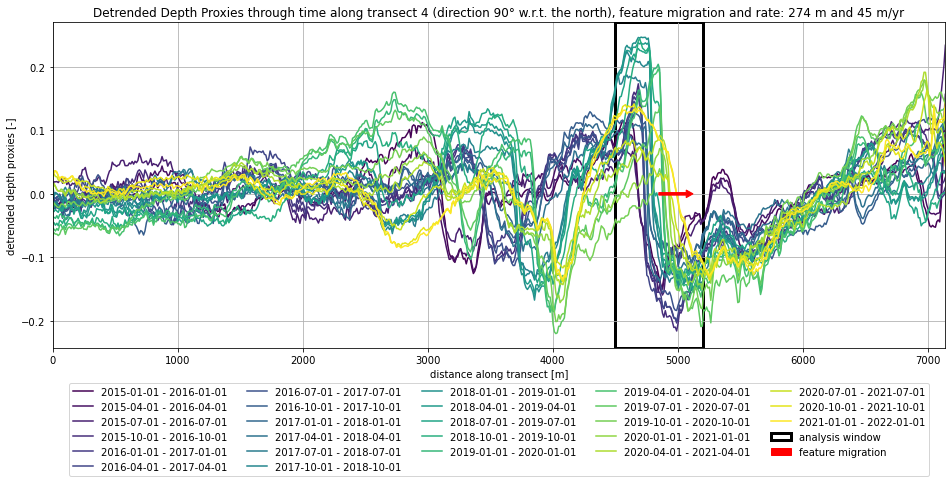

In [15]:
# calculate migration rate vector(s) for interesting areas along drawn / loaded transect(s)
# DISCLAIMER: always check the derived migration rate visually, 1D cross-correlation is just a statistics method and depends on
# your input parameters 'wnd' and 'interp'.

# specify analysis parameters by looking at transect plots
tr_sel = 4 # transect number for analysis
wnd = [4500, 5200] #[2900,4500]#[5200,5500]#[4500, 5200] # [m]
interp = 2 # specify interpolation resolution [m]

# calculate the year-to-year 1D cross-correlation
detr_zsfsl = []
detr_zsnsl = []
ctc_mr = []
for idx, (i, j) in enumerate(zip(detr_zs[tr_sel-1], tile_names)):
    if idx+1 == len(detr_zs[tr_sel-1]): break

    ffs = interpolate.interp1d(td_corr[tr_sel-1][idx], detr_zs[tr_sel-1][idx]) # interp first step
    fns = interpolate.interp1d(td_corr[tr_sel-1][idx+1], detr_zs[tr_sel-1][idx+1]) # interp next step
    
    td_corrfs = np.arange(td_corr[tr_sel-1][idx][0], td_corr[tr_sel-1][idx][-1], interp) # 1 m 
    td_corrns = np.arange(td_corr[tr_sel-1][idx+1][0], td_corr[tr_sel-1][idx+1][-1], interp) # 1 m 
    
    detr_zsfs = ffs(td_corrfs) # calculate new, interpolated y's
    detr_zsns = fns(td_corrns) # calculate new, interpolated y's
    detr_zsfsl.append(detr_zsfs), detr_zsnsl.append(detr_zsns)
    
    # find new windows
    xind_wsn = find_nearest(td_corrfs, wnd[0])
    xind_wen = find_nearest(td_corrfs, wnd[1])
    
    # 1D cross-correlation
    corr, lag = cross_corr(detr_zsns[xind_wsn:xind_wen], detr_zsfs[xind_wsn:xind_wen])
    ctc_mr.append(lag*interp)
    
    # time step
    datest = datetime.datetime.strptime(tile_times[idx].split(' - ')[0], "%Y-%m-%d")
    dateed = datetime.datetime.strptime(tile_times[idx+1].split(' - ')[0], "%Y-%m-%d")
    diff_date = relativedelta(dateed, datest)
    diff_date_fl = diff_date.years+diff_date.months/12

    # print statistics (migration distance and rate)
    #print('Composite to composite migration distance and rate: %s m and %s m/yr'%(lag*interp, (lag*interp)/diff_date_fl)) 
    
    # indicative figures for year to year migration 
    #plt.figure(figsize=(16,9))
    # displaced first timestep (achieved by adding +(interp*lag))
    #plt.plot(td_corrfs+(interp*lag), detr_zsfs, 'bo-', label='%s - %s'%(tile_names[idx].split('.')[0].split('_')[-2], 
    #                                                       tile_names[idx].split('.')[0].split('_')[-1]))
    # next timestep
    #plt.plot(td_corrns, detr_zsns, 'ro-', label='%s - %s'%(tile_names[idx+1].split('.')[0].split('_')[-2], 
    #                                                       tile_names[idx+1].split('.')[0].split('_')[-1])) 
    #plt.grid()
    #plt.legend()
    #plt.xlim(wnd[0], wnd[1])
    #plt.show()

# calculate the total 1D cross-correlation (i.e. last - first timestep)
corr, lag = cross_corr(detr_zsnsl[-1][xind_wsn:xind_wen], detr_zsfsl[0][xind_wsn:xind_wen])

# time step
datest = datetime.datetime.strptime(tile_times[0].split(' - ')[0], "%Y-%m-%d")
dateed = datetime.datetime.strptime(tile_times[-1].split(' - ')[0], "%Y-%m-%d")
diff_date = relativedelta(dateed, datest)
diff_date_fl = diff_date.years+diff_date.months/12

# direction
angle=math.degrees(math.atan2(trs[tr_sel-1].coords.xy[0][1] - trs[tr_sel-1].coords.xy[0][0], 
                              trs[tr_sel-1].coords.xy[1][1] - trs[tr_sel-1].coords.xy[1][0])) %360 # w.r.t degrees north

# print statistics (migration distance and rate)
if np.sum(ctc_mr) >= 0: # direction of drawn transect
    print('Composite to composite summed total migration and rate (direction %s\xb0 w.r.t. the north): %s m and %s m/yr'%(int(angle), np.sum(ctc_mr), np.sum(ctc_mr)/diff_date_fl))
elif np.sum(ctc_mr) < 0: # opposite direction of drawn transect
    print('Composite to composite summed total migration and rate (direction %s\xb0 w.r.t. the north): %s m and %s m/yr'%(int(angle)+180, np.sum(ctc_mr), np.sum(ctc_mr)/diff_date_fl))
if lag*interp >= 0: # direction of drawn transect
    print('Overall total migration (direction %s\xb0 w.r.t. the north): %s m and %s m/yr'%(int(angle), lag*interp, round(lag*interp/diff_date_fl,1)))
elif lag*interp < 0: # opposite direction of drawn transect
    print('Overall total migration (direction %s\xb0 w.r.t. the north): %s m and %s m/yr'%(int(angle)+180, lag*interp, round(lag*interp/diff_date_fl,1)))

# overview plot
mig_rate = 'ovl' # either 'ovl' for overall or 'yty' for year to year

plt.figure(figsize=(16,6))
if mig_rate == 'ovl':
    plt.title('Detrended Depth Proxies through time along transect %s (direction %s\xb0 w.r.t. the north), feature migration and rate: %s m and %s m/yr'%(tr_sel, int(angle), int(lag*interp), int(lag*interp/diff_date_fl)))
if mig_rate == 'yty':
    plt.title('Detrended Depth Proxies through time along transect %s (direction %s\xb0 w.r.t. the north), feature migration and rate: %s m and %s m/yr'%(tr_sel, int(angle), int(np.sum(ctc_mr)), int(np.sum(ctc_mr)/diff_date_fl)))

colors = cm.viridis(np.linspace(0, 1, len(tzg[tr_sel-1])))
for idx, (xs, ys, ds, dsc, zgs, masks, name, col) in enumerate(zip(tx[tr_sel-1], ty[tr_sel-1], td[tr_sel-1], td_corr[tr_sel-1], 
                                                                   tzg[tr_sel-1], tmask[tr_sel-1], tile_times, colors)):
    #if idx ==0  or idx==len(tx[tr_sel-1])-1:# or idx > 15: #
        # detrending and plotting
        masked = ~np.isnan(ds) & ~np.isnan(zgs)
        result = stats.linregress(ds[masked], zgs[masked])
        trend = result.intercept + result.slope*ds
        detrended = [zgs[j]-trend[j] for j in range(0, len(ds))]
        #RMSE = np.sqrt(np.nanmean(result.rvalue**2)) # root of the mean squared residual of the detrended fit
        #Rsq = result.rvalue**2 # R-squared residual of the detrended fit
        
        # plot by taking out the trend (bias, linear regression)
        plt.plot(dsc, detrended, color=col, label='%s - %s'%(name.split(' - ')[0], name.split(' - ')[-1]))

# show what is land
for idx, i in enumerate(dtrc[0][np.all(masktr, axis=0)]): # lengths where there is always land throughout the composites
    if idx == 0: plt.axvline(i, color='goldenrod', alpha=0.3, label='always land (verticals)')
    else: plt.axvline(i, color='goldenrod', alpha=0.3)
        
# analysis window
plt.axvspan(wnd[0], wnd[1], fill=False, color='k', linewidth=3, label='analysis window')
if mig_rate == 'ovl':
    plt.arrow(wnd[0]+(wnd[1]-wnd[0])/2, 0, lag*interp, 0, color='r', zorder=5, width=0.004, head_length=abs((1/5)*lag*interp), 
              length_includes_head=True, label='feature migration') # direction changes automatically with its lag sign
if mig_rate == 'yty':
    plt.arrow(wnd[0], 0, np.sum(ctc_mr), 0, color='r', zorder=5, width=0.004, head_length=abs((1/5)*np.sum(ctc_mr)), 
              length_includes_head=True, label='feature migration') # direction changes automatically with its lag sign  
        
# plot characteristics
plt.xlim(td_corr[tr_sel-1][0][0], td_corr[tr_sel-1][0][-1]);
plt.xlabel('distance along transect [m]')
plt.ylabel('detrended depth proxies [-]')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.09), ncol=5)
plt.grid()

# save figure
#plt.savefig(os.path.join(file_fol,'AOI\local', project_name+r'_transects\figs\transect_%s_compo_%s_analysis_window_%s_%s.png'%(tr_sel, compo_len, wnd[0], wnd[1])), 
#            bbox_inches='tight', facecolor='white')